Packages

In [1]:
#loading packages - there are lots and at this point I'm afraid my code will break if I remove any of them
library(rvest)
library(tidyverse)
library(dplyr)
library(ggplot2)
library(magrittr) 
library(purrr) 
library(glue)
library(stringr) 
library(httr)
library(jsonlite)
library(gapminder)
library(readxl)
library(lubridate)
library(visdat)
library(writexl)
library(visdat)
library(sf) #working with geographic simple features in R
library(rnaturalearth) #world map data from Natural Earth
library(countrycode) #get ISO code from country names
library(ggrepel) #"ggplot2" extension for overlapping text labels
library(geojsonio)

library(skimr)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()         masks stats::filter()
✖ readr::guess_encoding() masks rvest::guess_encoding()
✖ dplyr::lag()            masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract



Attaching package: 'jsonlite'


The following object is masked from 'package:purrr':

    flatten


Linking to GEOS 3.11.2, GDAL 3.7.2, PROJ 9.3.0; sf_u

Bringing in local data

In [2]:
#freedom index data
df_free = read_excel('polrights_fh.xlsx')

#BMI data 
df_bmi = read_csv('bmi_data.csv', show_col_types = FALSE)

#gini index data
df_gini = read_csv('ddf--datapoints--gapminder_gini--by--geo--time.csv', show_col_types = FALSE) 

#real gdp per capita data
df_gdp = read_csv('gdppercapita_us_inflation_adjusted.csv', show_col_types = FALSE) 

#sugar data
df_sugar = read_csv('sugar_per_person_g_per_day.csv', show_col_types = FALSE) 

#Bring in another dataset: 
#This dataset shows the percentage of premature deaths from non communicable diseases
# such as cancers, cardiovascular disease, diabetes and chronic lung illnesses.

premature_deaths <- read.csv('prematurencddeaths.csv')

bringing in country info from github

In [3]:
country_codes = fromJSON('https://gist.githubusercontent.com/bensquire/1ba2037079b69e38bb0d6aea4c4a0229/raw/8609a1a86683bbd6d0e4a7e9456eabf6e7b65b7f/countries.json')

df_countries = country_codes %>% #converting to dataframe and renaming variables
    mutate(country_code = code,
           country = name) %>%
    select(country_code, country, eu)

In [4]:
#this function allows a quick look at the contents of a dataframe
#just type it as quick_viz('dataframe name goes here')

quick_viz = function(dataframe) {
dataframe %>%
    glimpse() %>%
    vis_dat() 
    }

Rows: 249
Columns: 3
$ country_code <chr> "AFG", "ALA", "ALB", "DZA", "ASM", "AND", "AGO", "AIA", "…
$ country      <chr> "Afghanistan", "Åland Islands", "Albania", "Algeria", "Am…
$ eu           <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F…


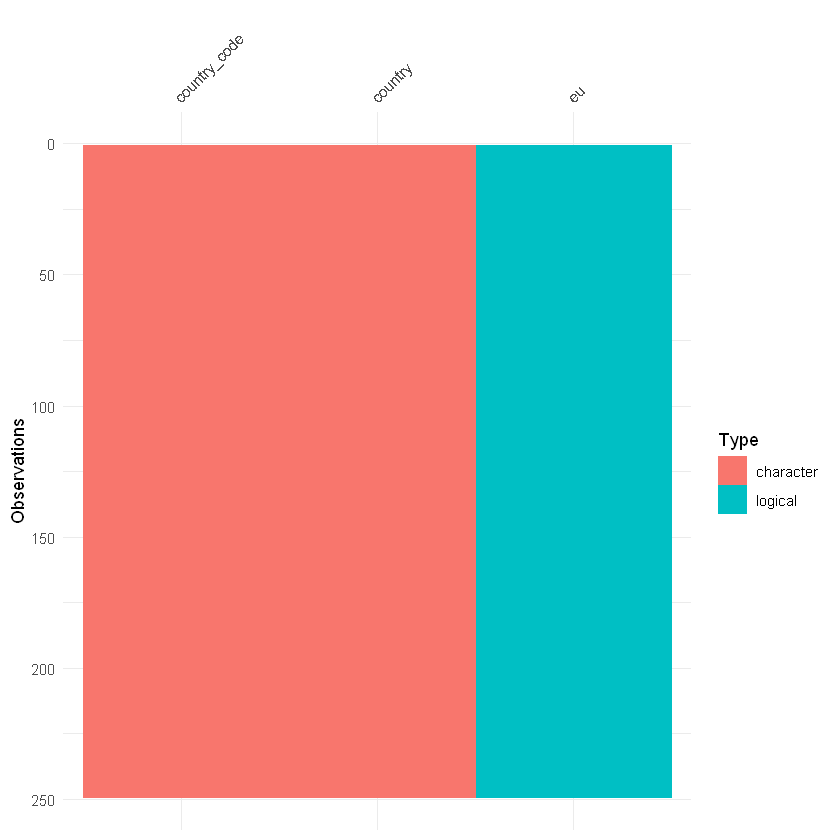

In [5]:
example_of_function = quick_viz(df_countries)

print(example_of_function)

In [6]:
#editing premature deaths dataframe so that it can merge with the bmi dataset
premature_deaths = premature_deaths %>%
  mutate(
    gender_code = case_when(
      gender_code %in% 'FMLE' ~ "Female",
      gender_code %in% 'MLE' ~ "Male",
      gender_code %in% 'BTSX' ~ "Other")) #need to match on sex, so have to recode to what I used for the BMI data


premature_deaths = premature_deaths %>%
    mutate(country_code = location_code, #once again, ensuring that the column names are the same
           country = location,
           year = as.numeric(period),
           gender = as.factor(gender_code),
           region = as.factor(region),
           region_code = as.factor(region_code)) %>%
    select(year, country, country_code, region, 
           region_code, gender, min_deaths, 
           max_deaths, deaths)

premature_deaths %>% head(1)

,year,country,country_code,region,region_code,gender,min_deaths,max_deaths,deaths
,<dbl>,<chr>,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,2019,Japan,JPN,Western Pacific,WPR,Female,9.07,12.2,10.42


Pivoting some data to match target format

In [7]:
#the gini coefficient data 
pivot_free = df_free %>%
    pivot_longer(cols = -country, names_to='year', #pivoting the data
                 values_to='Freedom_index')

pivot_free = pivot_free %>%
    filter(year > 1974, year < 2017) %>% #filtering to the same timespan
    mutate(Freedom_index = as.factor(Freedom_index),
          year = as.numeric(year))

In [8]:
#sugar consumption dataset 
pivot_sugar = df_sugar %>%
    pivot_longer(cols = -country, names_to='year', #pivoting the data
                 values_to='daily_sugar_pp_grams')

pivot_sugar = pivot_sugar %>%
    filter(year > 1974, year < 2017) %>% #filtering to the same timespan
    drop_na() %>%
    mutate(year = as.numeric(year))

In [9]:
#gdp/capita dataset
pivot_gdp = df_gdp %>%
    pivot_longer(cols = -country, names_to='year', #pivoting the data
                 values_to='GDP_per_capita')

pivot_gdp = pivot_gdp %>%
    filter(year > 1974, year < 2017) %>% #filtering to the same timespan
    mutate(year = as.numeric(year)) 

**Now it is time to clean some data** - the goal is to merge all of the data together.  

This will require changing column names and data types

Cleaning the gdp data, converting the GDP measures into the right data format

In [10]:
pivot_gdp <- pivot_gdp %>% 
  mutate(GDP_per_capita = as.numeric(str_replace_all(GDP_per_capita, 
                c( '\\.' = '', 'k' = '000')))) #replacing string representation of 'thousands'

Cleaning gini dataset - rename variables, convert country_code obs to upper case

In [11]:
df_gini_clean = df_gini %>%
    mutate(country_code = toupper(geo), #match the case of the codes
           year = time,
           gini = gapminder_gini) %>%
    filter(year > 1974, year < 2017) %>%
    select(country_code, year, gini)

Going to merge on country and year. Need to rename columns so they match

In [12]:
df_bmi = df_bmi %>%
    rename('country' = 'Location',
           'year' = 'Period',
            'country_code' = 'SpatialDimValueCode')

Ideally we would merge on country_codes, as that is a standard format.  Unfortunately, not all the datasets had these embedded, so we will merge on country until we get to the point that we can standardize.

This going to require some 'hand cranking' to get started.

In [13]:
#renaming countries so that merging works
pivot_sugar <- pivot_sugar %>%
  mutate(
    country = case_when(
      country %in% 'USA' ~ "United States",
      country %in% 'Bolivia' ~ "Bolivia, Plurinational State of",
      country %in% 'UK' ~ "United Kingdom",
      country %in% 'Russia' ~ "Russian Federation",
      country %in% 'North Korea' ~ "Korea, Democratic People's Republic of",
      country %in% 'South Korea' ~ "Korea, Republic of",
      country %in% 'Congo, Rep.' ~ "Congo",
      country %in% 'Tanzania' ~ "Tanzania, United Republic of",
      country %in% 'Vietnam' ~ "Viet Nam",
      country %in% 'Taiwan' ~ "Taiwan, Province of China",
      country %in% 'UAE' ~ "United Arab Emirates",
      country %in% "Czechoslovakia" ~ "Czech Republic",
      country %in% 'Cote d\'Ivoire' ~ "Côte d'Ivoire",
      country %in% 'Iran' ~ "Iran, Islamic Republic of",
      country %in% 'St. Kitts and Nevis' ~ "Saint Kitts and Nevis",
      country %in% 'Lao' ~ "Lao People's Democratic Republic",
      country %in% 'Brunei' ~ "Brunei Darussalam",
      country %in% 'Hong Kong, China' ~ "Hong Kong",
      country %in% 'Kyrgyz Republic' ~ "Kyrgyzstan",
      country %in% 'Macao, China' ~ "Macao",
      country %in% 'Moldova' ~ "Moldova, Republic of",
      country %in% 'Macedonia' ~ "Macedonia, the former Yugoslav Republic of",
      country %in% 'St. Lucia' ~ "Saint Lucia",
      country %in% 'St. Vincent and the Grenadines' ~ "Saint Vincent and the Grenadines",
      country %in% 'Slovak Republic' ~ "Slovakia",
      country %in% 'Venezuela' ~ "Venezuela, Bolivarian Republic of",
      TRUE ~ country
    )
  )


Now join the new gini df with the freedom index data

In [14]:
#renaming countries again

pivot_free <- pivot_free %>%
  mutate(
    country = case_when(
      country %in% 'USA' ~ "United States",
      country %in% 'Venezuela' ~ "Venezuela, Bolivarian Republic of",
      country %in% 'Brunei' ~ "Brunei Darussalam",
      country %in% 'UAE' ~ "United Arab Emirates",
      country %in% 'Cote d\'Ivoire' ~ "Côte d'Ivoire",
      country %in% 'Congo, Rep.' ~ "Congo",
      country %in% 'UK' ~ "United Kingdom",
      country %in% 'Iran' ~ "Iran, Islamic Republic of",
      country %in% 'Lao' ~ "Lao People's Democratic Republic",
      country %in% 'St. Kitts and Nevis' ~ "Saint Kitts and Nevis",
      country %in% 'South Korea' ~ "Korea, Republic of",
      country %in% 'St. Lucia' ~ "Saint Lucia",
      country %in% 'Moldova' ~ "Moldova, Republic of",
      country %in% 'Macedonia' ~ "Macedonia, the former Yugoslav Republic of",
      country %in% 'North Korea' ~ "Korea, Democratic People's Republic of",
      country %in% 'Russia' ~ "Russian Federation",
      country %in% 'Slovak Republic' ~ "Slovakia",
      country %in% 'St. Vincent and the Grenadines' ~ "Saint Vincent and the Grenadines",
      country %in% 'Vietnam' ~ "Viet Nam",
      country %in% 'Bolivia' ~ "Bolivia, Plurinational State of",
      country %in% 'Kyrgyz Republic' ~ "Kyrgyzstan",
      country %in% 'North Macedonia' ~ "Macedonia, the former Yugoslav Republic of",
      TRUE ~ country
    )
  )


In [15]:
#and again

pivot_gdp <- pivot_gdp %>%
  mutate(
    country = case_when(
      country %in% 'USA' ~ "United States",
      country %in% 'UAE' ~ "United Arab Emirates",
      country %in% 'Bolivia' ~ "Bolivia, Plurinational State of",
      country %in% 'Brunei' ~ "Brunei Darussalam",
      country %in% 'Cote d\'Ivoire' ~ "Côte d'Ivoire",
      country %in% 'Congo, Rep.' ~ "Congo",
      country %in% 'UK' ~ "United Kingdom",
      country %in% 'Iran' ~ "Iran, Islamic Republic of",
      country %in% 'St. Kitts and Nevis' ~ "Saint Kitts and Nevis",
      country %in% 'South Korea' ~ "Korea, Republic of",
      country %in% 'Lao' ~ "Lao People's Democratic Republic",
      country %in% 'St. Lucia' ~ "Saint Lucia",
      country %in% 'Moldova' ~ "Moldova, Republic of",
      country %in% 'Macedonia' ~ "Macedonia, the former Yugoslav Republic of",
      country %in% 'North Korea' ~ "Korea, Democratic People's Republic of",
      country %in% 'Russia' ~ "Russian Federation",
      country %in% 'St. Vincent and the Grenadines' ~ "Saint Vincent and the Grenadines",
      country %in% 'Venezuela' ~ "Venezuela, Bolivarian Republic of",
      country %in% 'Vietnam' ~ "Viet Nam",
      TRUE ~ country
    )
  )


Now it's time to start merging all the data together.

Now we can combine the sugar data with the country data.  This will allow us to merge it more simply in the future.

In [16]:
#this adds the pivoted sugar df with the df of all countries and iso3 codes

sugar_df = inner_join(pivot_sugar, df_countries, by =('country'))
head(sugar_df, 2)

country,year,daily_sugar_pp_grams,country_code,eu
<chr>,<dbl>,<dbl>,<chr>,<lgl>
Afghanistan,1975,14.9,AFG,FALSE
Afghanistan,1976,15.7,AFG,FALSE


In [17]:
#this adds the cleaned gini df to the df of all countries and iso3 codes

gini_df = inner_join(df_gini_clean, df_countries, by = 'country_code')
head(gini_df, 2)

country_code,year,gini,country,eu
<chr>,<dbl>,<dbl>,<chr>,<lgl>
AFG,1975,32.1,Afghanistan,FALSE
AFG,1976,32.2,Afghanistan,FALSE


In [18]:
#inner join of freedom data and country/iso3 code data
merged_free <- inner_join(pivot_free, gini_df, by = c('country', 'year'))

In [19]:
#inner join of 
merged_freegdp <- inner_join(merged_free, pivot_gdp, by = c('country', 'year'))

In [21]:
merged_all_bmi = inner_join(merged_freegdp, df_bmi, by = c('year', 'country_code'))
head(merged_all_bmi, 2)

country.x,year,Freedom_index,country_code,gini,eu,GDP_per_capita,IndicatorCode,Indicator,ValueType,⋯,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
<chr>,<dbl>,<fct>,<chr>,<dbl>,<lgl>,<dbl>,<chr>,<chr>,<chr>,⋯,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dttm>
Afghanistan,1975,7,AFG,32.1,FALSE,NA,NCD_BMI_MEAN,Mean BMI (kg/m²) (age-standardized estimate),numeric,⋯,NA,NA,15.8,NA,21.9,18.9 [15.8 – 21.9],NA,NA,EN,2017-09-26 11:00:00
Afghanistan,1975,7,AFG,32.1,FALSE,NA,NCD_BMI_MEAN,Mean BMI (kg/m²) (age-standardized estimate),numeric,⋯,NA,NA,16.9,NA,21.0,18.9 [16.9 – 21],NA,NA,EN,2017-09-26 11:00:00


Now we have a dataframe that contains (almost) all the data we collected.  Need to convert the column names and improve the readability.  

In [22]:
#renaming the columns and adjusting datatypes
merged_all_bmi = merged_all_bmi %>%
    mutate(region_code = as.factor(ParentLocationCode),
           country_code = as.factor(country_code),
           region = as.factor(ParentLocation),
           gender = Dim1,
           age = as.factor(Dim2),
           bmi_ave = FactValueNumeric,
           bmi_low = FactValueNumericLow,
           bmi_high = FactValueNumericHigh,
           EU_member = eu)

merged_all_bmi$gender[merged_all_bmi$gender %in% 'Both sexes'] <- "Other"

In [23]:
merged_dff = inner_join(merged_all_bmi, sugar_df, by = c('year', 'country_code'))
head(merged_dff, 2)

country.x,year,Freedom_index,country_code,gini,eu.x,GDP_per_capita,IndicatorCode,Indicator,ValueType,⋯,region,gender,age,bmi_ave,bmi_low,bmi_high,EU_member,country,daily_sugar_pp_grams,eu.y
<chr>,<dbl>,<fct>,<chr>,<dbl>,<lgl>,<dbl>,<chr>,<chr>,<chr>,⋯,<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<lgl>
Afghanistan,1975,7,AFG,32.1,FALSE,NA,NCD_BMI_MEAN,Mean BMI (kg/m²) (age-standardized estimate),numeric,⋯,Eastern Mediterranean,Female,18+ years,18.9,15.8,21.9,FALSE,Afghanistan,14.9,FALSE
Afghanistan,1975,7,AFG,32.1,FALSE,NA,NCD_BMI_MEAN,Mean BMI (kg/m²) (age-standardized estimate),numeric,⋯,Eastern Mediterranean,Other,18+ years,18.9,16.9,21.0,FALSE,Afghanistan,14.9,FALSE


We have a dataframe that we will now use to analyze the data.

In [24]:
#keep the relevant rows
dff = merged_dff %>%
    select(year, country, Freedom_index, gini, GDP_per_capita,
           region, region_code, country_code, EU_member, gender, 
           daily_sugar_pp_grams, bmi_ave, bmi_low, bmi_high
       )
head(dff, 2)

year,country,Freedom_index,gini,GDP_per_capita,region,region_code,country_code,EU_member,gender,daily_sugar_pp_grams,bmi_ave,bmi_low,bmi_high
<dbl>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1975,Afghanistan,7,32.1,NA,Eastern Mediterranean,EMR,AFG,FALSE,Female,14.9,18.9,15.8,21.9
1975,Afghanistan,7,32.1,NA,Eastern Mediterranean,EMR,AFG,FALSE,Other,14.9,18.9,16.9,21.0


Rows: 18,975
Columns: 14
$ year                 <dbl> 1975, 1975, 1975, 1976, 1976, 1976, 1977, 1977, 1…
$ country              <chr> "Afghanistan", "Afghanistan", "Afghanistan", "Afg…
$ Freedom_index        <fct> 7, 7, 7, 7, 7, 7, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7…
$ gini                 <dbl> 32.1, 32.1, 32.1, 32.2, 32.2, 32.2, 32.2, 32.2, 3…
$ GDP_per_capita       <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ region               <fct> Eastern Mediterranean, Eastern Mediterranean, Eas…
$ region_code          <fct> EMR, EMR, EMR, EMR, EMR, EMR, EMR, EMR, EMR, EMR,…
$ country_code         <chr> "AFG", "AFG", "AFG", "AFG", "AFG", "AFG", "AFG", …
$ EU_member            <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, …
$ gender               <chr> "Female", "Other", "Male", "Female", "Other", "Ma…
$ daily_sugar_pp_grams <dbl> 14.9, 14.9, 14.9, 15.7, 15.7, 15.7, 16.5, 16.5, 1…
$ bmi_ave              <dbl> 18.9, 18.9, 19.0, 19.0, 19.0, 19.1, 19.1, 19.2, 1…
$ bmi_low      

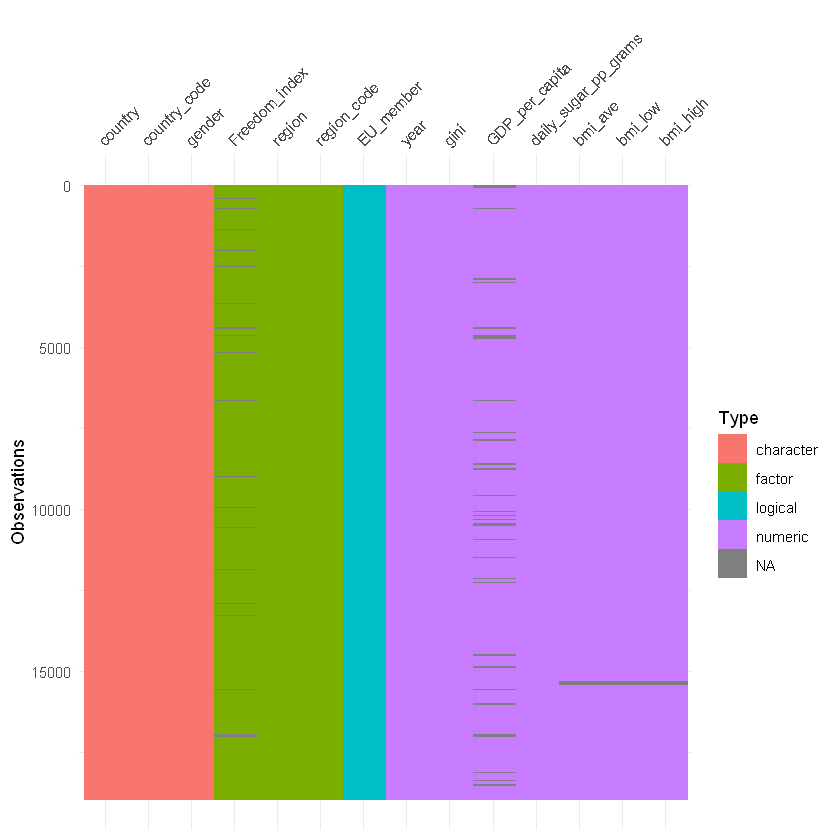

In [26]:
#check the results
dff %>%
    glimpse() %>%
    vis_dat() 

Mostly complete, data types are correct.  Next we bring in geometric data to help make maps!

In [27]:
world <- ne_countries(scale = "small", returnclass = "sf")

dfmap <- world %>% #merging the geometric information with the dataframe
  select(geometry, iso_a3) %>%
  inner_join(dff, 
            by = c("iso_a3" = "country_code")) %>%
  rename(country_code = iso_a3)

**Bringing in the death data**

Now time to combine with the premature deaths dataset - this one runs from 2000-2019, so we will only have values for 2000-2016

In [28]:
dfmap_ncd = left_join(dfmap, premature_deaths, 
                      by = c('year', 'country_code', 'gender')) %>%
            select(-country.y, -region.y, -region_code.y) %>%
            rename(country = country.x, 
                   region = region.x,
                   region_code = region_code.x)
head(dfmap_ncd)

,country_code,year,country,Freedom_index,gini,GDP_per_capita,region,region_code,EU_member,gender,daily_sugar_pp_grams,bmi_ave,bmi_low,bmi_high,min_deaths,max_deaths,deaths,geometry
,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<MULTIPOLYGON [°]>
1,FJI,1975,Fiji,2,39.7,3270,Western Pacific,WPR,FALSE,Male,88.5,22.4,20.1,24.5,NA,NA,NA,MULTIPOLYGON (((180 -16.067...
2,FJI,1975,Fiji,2,39.7,3270,Western Pacific,WPR,FALSE,Other,88.5,23.2,21.4,25.0,NA,NA,NA,MULTIPOLYGON (((180 -16.067...
3,FJI,1975,Fiji,2,39.7,3270,Western Pacific,WPR,FALSE,Female,88.5,24.1,21.3,27.0,NA,NA,NA,MULTIPOLYGON (((180 -16.067...
4,FJI,1976,Fiji,2,39.3,3300,Western Pacific,WPR,FALSE,Male,88.7,22.5,20.4,24.5,NA,NA,NA,MULTIPOLYGON (((180 -16.067...
5,FJI,1976,Fiji,2,39.3,3300,Western Pacific,WPR,FALSE,Other,88.7,23.4,21.7,25.0,NA,NA,NA,MULTIPOLYGON (((180 -16.067...
6,FJI,1976,Fiji,2,39.3,3300,Western Pacific,WPR,FALSE,Female,88.7,24.3,21.5,27.0,NA,NA,NA,MULTIPOLYGON (((180 -16.067...


In [29]:
#removing the missing values
dfmap_ncd = dfmap_ncd %>% 
    na.omit()

head(dfmap_ncd, 1)

,country_code,year,country,Freedom_index,gini,GDP_per_capita,region,region_code,EU_member,gender,daily_sugar_pp_grams,bmi_ave,bmi_low,bmi_high,min_deaths,max_deaths,deaths,geometry
,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<MULTIPOLYGON [°]>
76,FJI,2000,Fiji,6,38,4000,Western Pacific,WPR,FALSE,Male,78.8,25.1,24.4,25.7,62.74,74.91,69.29,MULTIPOLYGON (((180 -16.067...


**Averaging BMI by gender**

Get the averages of the three genders (Male, Female, Other):

In [28]:
# Split the dataset into groups of three rows
groups <- split(dfmap_ncd, rep(1:ceiling(nrow(dfmap_ncd)/3), each = 3, length.out = nrow(dfmap_ncd)))

# Calculate the average for the "bmi_ave" column in each group
averages <- lapply(groups, function(group) {
  mean(group$bmi_ave, na.rm = TRUE)
})

# Convert the list of averages into a data frame
average_data <- data.frame(Group = names(averages), Average = sapply(averages, mean))




In [29]:
average_data %>% head() 
average_data %>% nrow()

dfmap_ncd %>% nrow()

,Group,Average
,<chr>,<dbl>
1,1,26.26667
2,2,26.36667
3,3,26.43333
4,4,26.50000
5,5,26.60000
6,6,26.70000


[1] 2418

[1] 7254

Now I have found the average bmis for each of the genders We need to duplicate each row twice so we have three rows for each observations so that it can join nicely with the original dataset:

In [30]:
# Duplicate every row twice
average_data_tripled <- average_data[rep(seq_len(nrow(average_data)), each = 3), ]

# Reset the row names if needed
rownames(average_data_tripled) <- NULL

Nice! - The average values are correct, the number of rows is correct - this looks like it will join nicely. But first we need to remove the 'Group' Row because it is useless.

In [31]:
average_data_tripled <- average_data_tripled %>%
    subset(select = -Group)

In [32]:
head(average_data_tripled)

,Average
,<dbl>
1,26.26667
2,26.26667
3,26.26667
4,26.36667
5,26.36667
6,26.36667


Now that useless column is gone we can join this table to our dataset:

In [33]:
merged_data <- data.frame(dfmap_ncd, average_data_tripled)


In [34]:
merged_data %>% head()
merged_data %>% tail()

,country_code,year,country,Freedom_index,gini,GDP_per_capita,region,region_code,EU_member,gender,daily_sugar_pp_grams,bmi_ave,bmi_low,bmi_high,min_deaths,max_deaths,deaths,geometry,Average
,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<MULTIPOLYGON [°]>,<dbl>
76,FJI,2000,Fiji,6,38.0,4000,Western Pacific,WPR,FALSE,Male,78.8,25.1,24.4,25.7,62.74,74.91,69.29,MULTIPOLYGON (((180 -16.067...,26.26667
77,FJI,2000,Fiji,6,38.0,4000,Western Pacific,WPR,FALSE,Other,78.8,26.3,25.7,26.8,61.26,74.39,68.41,MULTIPOLYGON (((180 -16.067...,26.26667
78,FJI,2000,Fiji,6,38.0,4000,Western Pacific,WPR,FALSE,Female,78.8,27.4,26.7,28.2,59.27,73.73,67.26,MULTIPOLYGON (((180 -16.067...,26.26667
79,FJI,2001,Fiji,4,38.1,4040,Western Pacific,WPR,FALSE,Male,90.4,25.2,24.6,25.8,62.10,73.94,68.42,MULTIPOLYGON (((180 -16.067...,26.36667
80,FJI,2001,Fiji,4,38.1,4040,Western Pacific,WPR,FALSE,Other,90.4,26.4,25.9,26.8,60.64,73.45,67.56,MULTIPOLYGON (((180 -16.067...,26.36667
81,FJI,2001,Fiji,4,38.1,4040,Western Pacific,WPR,FALSE,Female,90.4,27.5,26.8,28.3,58.59,72.79,66.38,MULTIPOLYGON (((180 -16.067...,26.36667


,country_code,year,country,Freedom_index,gini,GDP_per_capita,region,region_code,EU_member,gender,daily_sugar_pp_grams,bmi_ave,bmi_low,bmi_high,min_deaths,max_deaths,deaths,geometry,Average
,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<MULTIPOLYGON [°]>,<dbl>
16954,TTO,2015,Trinidad and Tobago,2,41.3,184000,Americas,AMR,FALSE,Male,173,26.5,24.8,28.1,39.65,60.23,50.41,MULTIPOLYGON (((-61.68 10.7...,27.5
16955,TTO,2015,Trinidad and Tobago,2,41.3,184000,Americas,AMR,FALSE,Other,173,27.5,26.2,28.8,37.06,57.64,47.68,MULTIPOLYGON (((-61.68 10.7...,27.5
16956,TTO,2015,Trinidad and Tobago,2,41.3,184000,Americas,AMR,FALSE,Female,173,28.5,26.5,30.4,33.97,54.40,44.32,MULTIPOLYGON (((-61.68 10.7...,27.5
16957,TTO,2016,Trinidad and Tobago,2,41.3,17000,Americas,AMR,FALSE,Male,181,26.6,24.8,28.3,38.43,59.73,49.58,MULTIPOLYGON (((-61.68 10.7...,27.6
16958,TTO,2016,Trinidad and Tobago,2,41.3,17000,Americas,AMR,FALSE,Other,181,27.6,26.2,28.9,36.04,57.40,47.10,MULTIPOLYGON (((-61.68 10.7...,27.6
16959,TTO,2016,Trinidad and Tobago,2,41.3,17000,Americas,AMR,FALSE,Female,181,28.6,26.5,30.6,33.15,54.46,44.05,MULTIPOLYGON (((-61.68 10.7...,27.6


In [35]:
#rename the new columns:
merged_data <- merged_data %>%
    rename(bmi_ave_gender = Average)

In [36]:
head(merged_data[19])

,bmi_ave_gender
,<dbl>
76,26.26667
77,26.26667
78,26.26667
79,26.36667
80,26.36667
81,26.36667


**Average Deaths**

For the Deaths accross time plot we need to find the average deaths for all genders, so we will repeat the process but for the deaths:


In [37]:
# Split the dataset into groups of three rows
groups <- split(dfmap_ncd, rep(1:ceiling(nrow(dfmap_ncd)/3), each = 3, length.out = nrow(dfmap_ncd)))

# Calculate the average for the "bmi_ave" column in each group
averages <- lapply(groups, function(group) {
  mean(group$deaths, na.rm = TRUE)
})

# Convert the list of averages into a data frame
average_data <- data.frame(Group = names(averages), Average = sapply(averages, mean))




In [38]:
average_data %>% head() 
average_data %>% nrow()

dfmap_ncd %>% nrow()

,Group,Average
,<chr>,<dbl>
1,1,68.32000
2,2,67.45333
3,3,66.76000
4,4,66.59667
5,5,67.49333
6,6,69.15333


[1] 2418

[1] 7254

In [39]:
# Duplicate every row twice
average_data_tripled <- average_data[rep(seq_len(nrow(average_data)), each = 3), ]

# Reset the row names if needed
rownames(average_data_tripled) <- NULL


In [40]:
average_data_tripled <- average_data_tripled %>%
    subset(select = -Group)

head(average_data_tripled)

,Average
,<dbl>
1,68.32000
2,68.32000
3,68.32000
4,67.45333
5,67.45333
6,67.45333


In [41]:
merged_data <- data.frame(merged_data, average_data_tripled)

In [42]:
head(merged_data)

,country_code,year,country,Freedom_index,gini,GDP_per_capita,region,region_code,EU_member,gender,daily_sugar_pp_grams,bmi_ave,bmi_low,bmi_high,min_deaths,max_deaths,deaths,geometry,bmi_ave_gender,Average
,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<MULTIPOLYGON [°]>,<dbl>,<dbl>
76,FJI,2000,Fiji,6,38.0,4000,Western Pacific,WPR,FALSE,Male,78.8,25.1,24.4,25.7,62.74,74.91,69.29,MULTIPOLYGON (((180 -16.067...,26.26667,68.32000
77,FJI,2000,Fiji,6,38.0,4000,Western Pacific,WPR,FALSE,Other,78.8,26.3,25.7,26.8,61.26,74.39,68.41,MULTIPOLYGON (((180 -16.067...,26.26667,68.32000
78,FJI,2000,Fiji,6,38.0,4000,Western Pacific,WPR,FALSE,Female,78.8,27.4,26.7,28.2,59.27,73.73,67.26,MULTIPOLYGON (((180 -16.067...,26.26667,68.32000
79,FJI,2001,Fiji,4,38.1,4040,Western Pacific,WPR,FALSE,Male,90.4,25.2,24.6,25.8,62.10,73.94,68.42,MULTIPOLYGON (((180 -16.067...,26.36667,67.45333
80,FJI,2001,Fiji,4,38.1,4040,Western Pacific,WPR,FALSE,Other,90.4,26.4,25.9,26.8,60.64,73.45,67.56,MULTIPOLYGON (((180 -16.067...,26.36667,67.45333
81,FJI,2001,Fiji,4,38.1,4040,Western Pacific,WPR,FALSE,Female,90.4,27.5,26.8,28.3,58.59,72.79,66.38,MULTIPOLYGON (((180 -16.067...,26.36667,67.45333


In [43]:
merged_data <- merged_data %>%
    rename(deaths_average_gender = Average)

In [44]:
head(merged_data)

,country_code,year,country,Freedom_index,gini,GDP_per_capita,region,region_code,EU_member,gender,daily_sugar_pp_grams,bmi_ave,bmi_low,bmi_high,min_deaths,max_deaths,deaths,geometry,bmi_ave_gender,deaths_average_gender
,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<MULTIPOLYGON [°]>,<dbl>,<dbl>
76,FJI,2000,Fiji,6,38.0,4000,Western Pacific,WPR,FALSE,Male,78.8,25.1,24.4,25.7,62.74,74.91,69.29,MULTIPOLYGON (((180 -16.067...,26.26667,68.32000
77,FJI,2000,Fiji,6,38.0,4000,Western Pacific,WPR,FALSE,Other,78.8,26.3,25.7,26.8,61.26,74.39,68.41,MULTIPOLYGON (((180 -16.067...,26.26667,68.32000
78,FJI,2000,Fiji,6,38.0,4000,Western Pacific,WPR,FALSE,Female,78.8,27.4,26.7,28.2,59.27,73.73,67.26,MULTIPOLYGON (((180 -16.067...,26.26667,68.32000
79,FJI,2001,Fiji,4,38.1,4040,Western Pacific,WPR,FALSE,Male,90.4,25.2,24.6,25.8,62.10,73.94,68.42,MULTIPOLYGON (((180 -16.067...,26.36667,67.45333
80,FJI,2001,Fiji,4,38.1,4040,Western Pacific,WPR,FALSE,Other,90.4,26.4,25.9,26.8,60.64,73.45,67.56,MULTIPOLYGON (((180 -16.067...,26.36667,67.45333
81,FJI,2001,Fiji,4,38.1,4040,Western Pacific,WPR,FALSE,Female,90.4,27.5,26.8,28.3,58.59,72.79,66.38,MULTIPOLYGON (((180 -16.067...,26.36667,67.45333


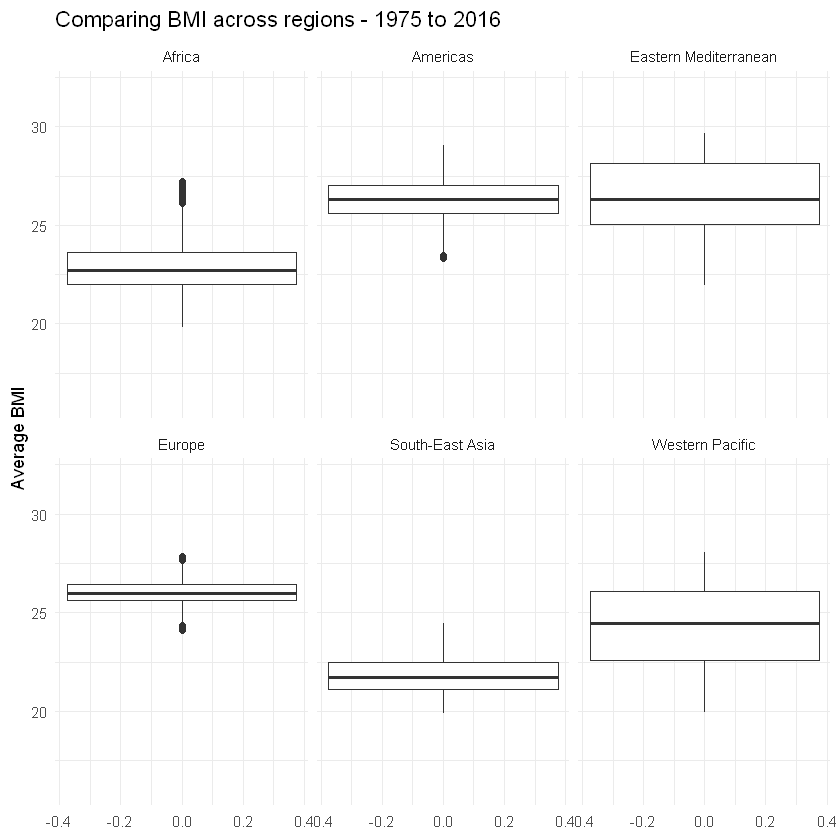

In [45]:
plot1 = merged_data %>%
        ggplot(aes(y = bmi_ave_gender)) +
        geom_boxplot() +
        facet_wrap(~region) +
        theme_minimal() +
        labs(title = 'Comparing BMI across regions - 1975 to 2016',
             y = 'Average BMI') +
        ylim(16, 32)

plot1

We can see that the East Mediterranean & Western Pacific have the largest inter quartile ranges.  This may be indicative of wealth inequality or other social features of the country.  Africa is also interesting, as the median is relatively low but there are a cluster of outliers above the maximum.  This is worth investigating more.

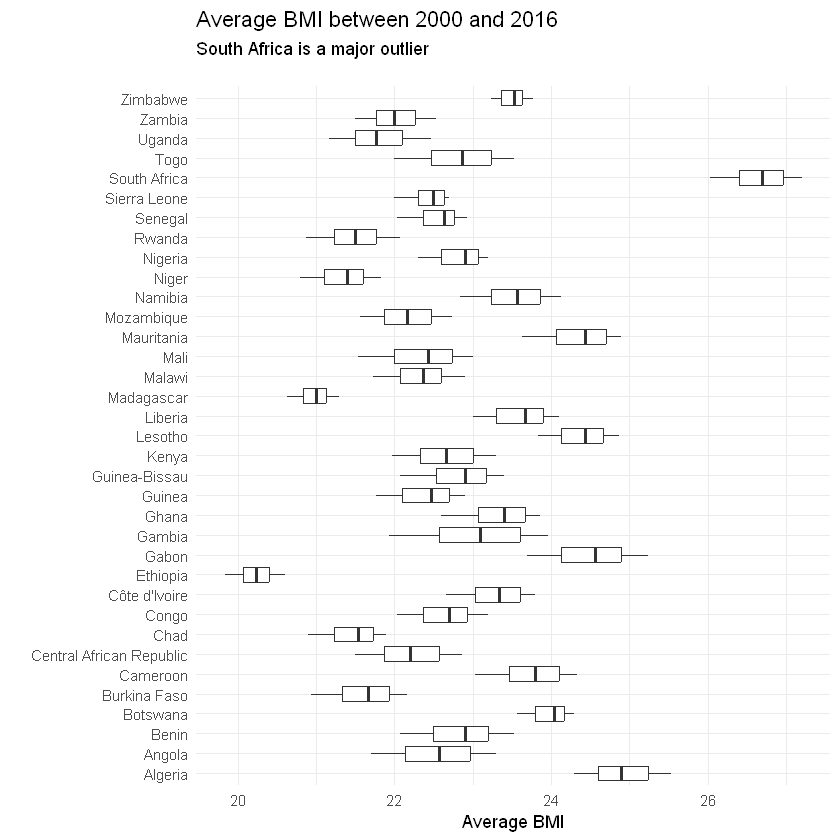

In [46]:
plot2 = merged_data %>% 
    filter(region == 'Africa') %>%
        ggplot(aes(
            x=bmi_ave_gender,
            y=country)) +
        geom_boxplot() +
        theme_minimal() +    
    labs(title = 'Average BMI between 2000 and 2016',
         subtitle = 'South Africa is a major outlier\n',
        x = 'Average BMI',
        y =  '')
plot2

South Africa is a large outlier.  And it appears that they are accountable for what we observed in plot1.

Here is a plot of the evolution of BMI from 1975 to 2016.  

It is interesting to note that the countries that can be seen entering the series during the 1980's or later are typically below average.  It would appear that more developed countries have higher BMI - this is not groundbreaking, but it is interesting to see it in the data.

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
"Removed 126 rows containing non-finite values (`stat_smooth()`)."


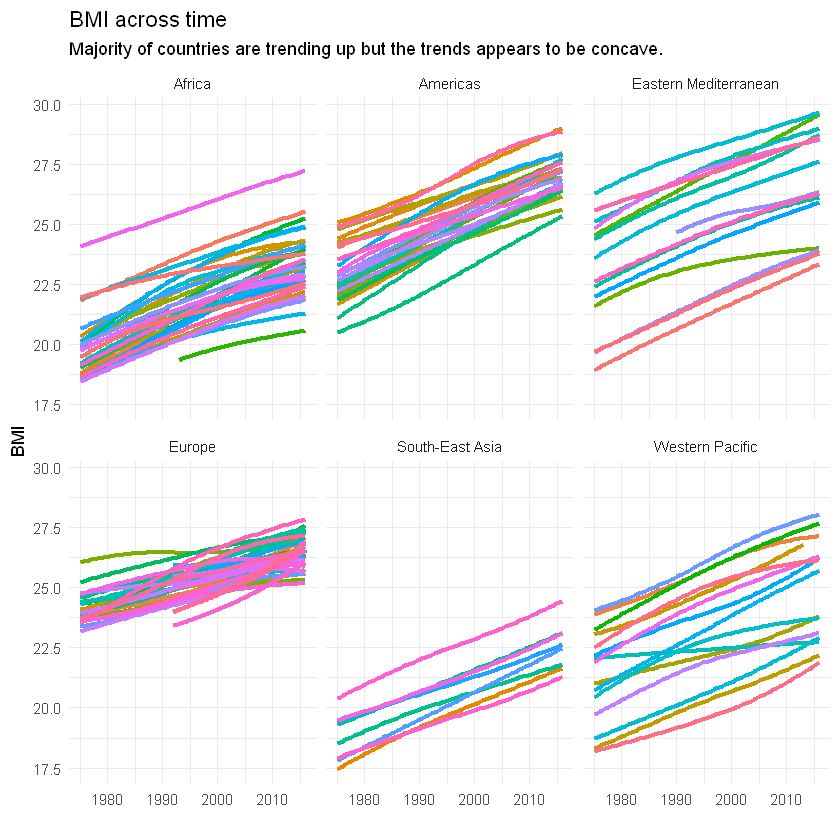

In [47]:
bmi_ts = dfmap %>% 
  ggplot(aes(x = year, 
             y = bmi_ave, 
             colour = country)) + 
  geom_smooth(se = FALSE, linewidth=1.2) + #removes the standard bars and sets line width
  labs(title = 'BMI across time',
       subtitle = 'Majority of countries are trending up but the trends appears to be concave.',
       x = '',
       y = 'BMI',
       colour = '') +
  facet_wrap(~region) + #this creates a graph for each region
  theme_minimal() + #I like how this looks
  guides(colour = "none")  #this line removes the colour legend

bmi_ts

**World Maps:**

we will make some comparisions across time between countries.  First set will look at daily sugar consumption and the second will look at average BMI.

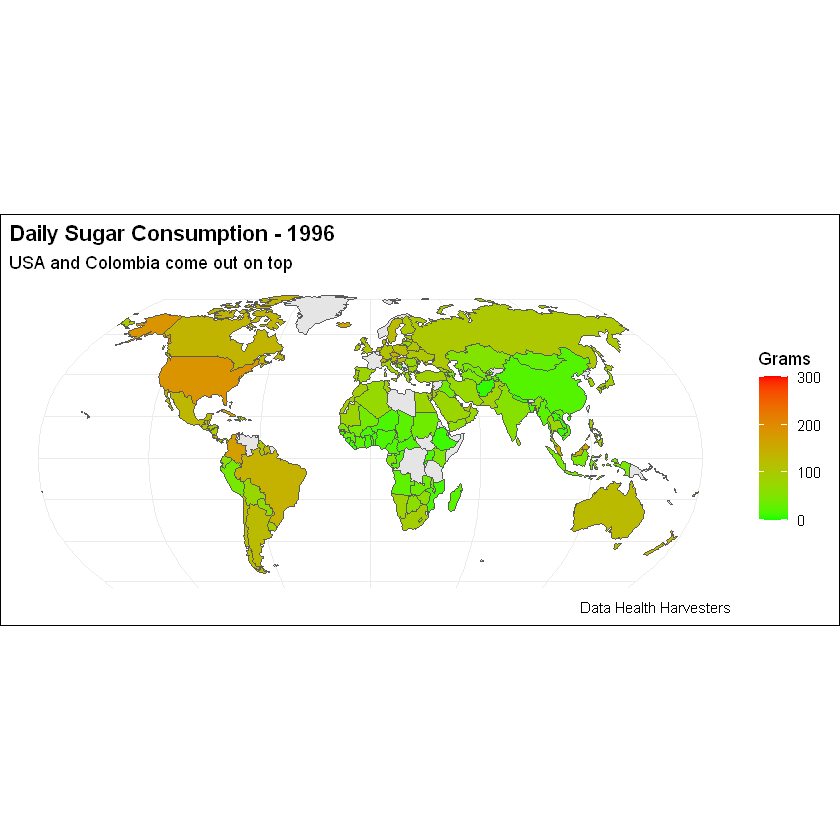

In [48]:
world_plot_sugar_96 <- world %>%
  filter(admin != "Antarctica") %>%
  st_transform(crs = "+proj=robin") %>%
  ggplot() +
  geom_sf() + #this keeps the outlines of the countries if they're omitted
  geom_sf(data = dfmap %>% 
          filter(year == 1996), 
          aes(fill = daily_sugar_pp_grams)) +
  scale_fill_gradient(limits = c(0, 300), #need to set a limit on thresholds to allow comparison 
                      low = 'green',      #between the charts with a significant level difference over 20 years
                      high = 'red', 
                      na.value = 'gray') +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold"),
    axis.text.x = element_blank(),
    plot.background = element_rect(fill = "white"),  #set the background color for the entire chart area
    panel.background = element_blank()  #remove the panel background
  ) +
  labs(title = "Daily Sugar Consumption - 1996",
       subtitle = 'USA and Colombia come out on top',
       x = NULL, y = NULL,
      caption = 'Data Health Harvesters',
      fill = 'Grams')

world_plot_sugar_96

Here we can see more recent data.  It appears that most of Asia and Africa have retained relatively low levels of sugar consumption.

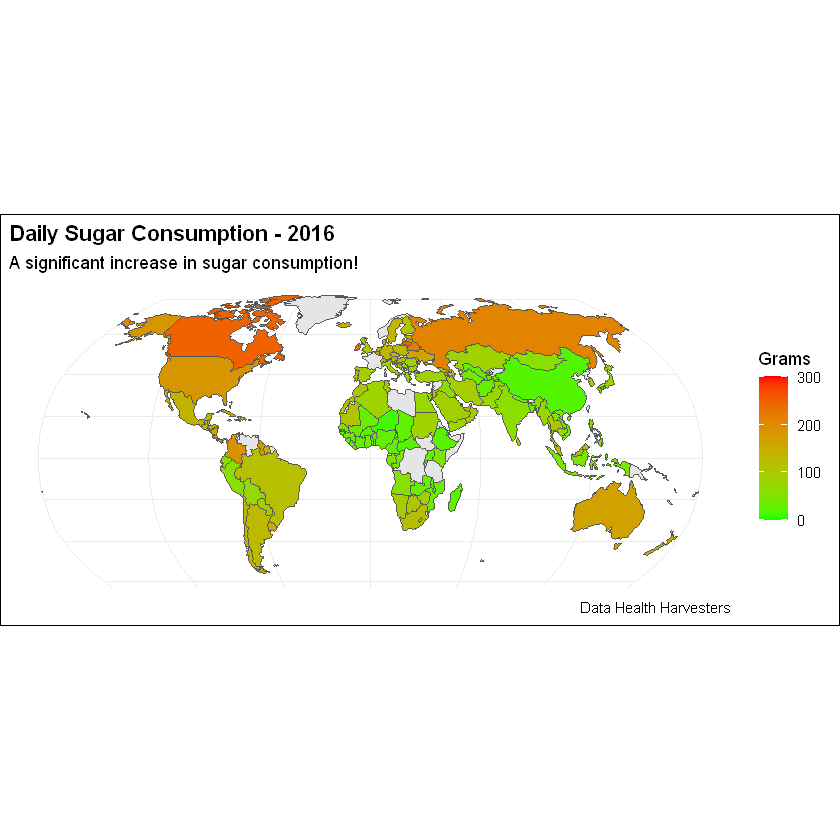

In [49]:
world_plot_sugar_16 <- world %>%
  filter(admin != "Antarctica") %>%
  st_transform(crs = "+proj=robin") %>%
  ggplot() +
  geom_sf() +
  geom_sf(data = dfmap %>% 
          filter(year == 2016), 
          aes(fill = daily_sugar_pp_grams)) +
  scale_fill_gradient(limits = c(0, 300), 
                      low = 'green', 
                      high = 'red', 
                      na.value = 'gray') +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold"),
    axis.text.x = element_blank(),
    plot.background = element_rect(fill = "white"),  
    panel.background = element_blank()  
  ) +
  labs(title = "Daily Sugar Consumption - 2016",
       subtitle = 'A significant increase in sugar consumption!',
       x = NULL, y = NULL,
      caption = 'Data Health Harvesters',
      fill = 'Grams')

#ggsave("world_plot_sugar_.png", plot = world_plot_sugar)
world_plot_sugar_16

Similarly, for BMI we will look at a 20 year period from 1996.

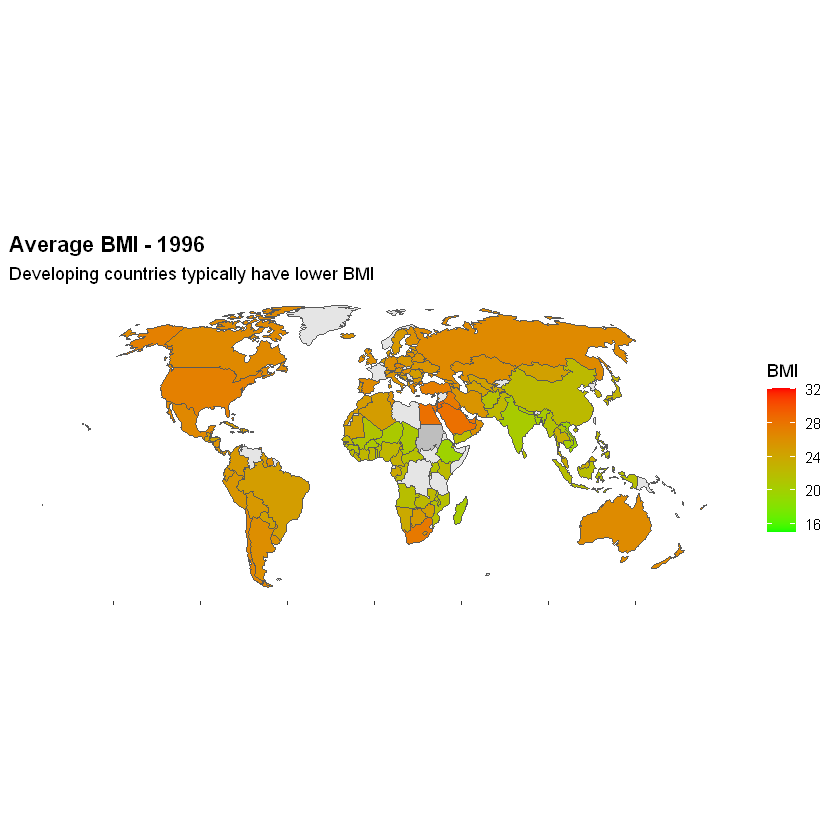

In [50]:
world_plot_bmi_96 <- world %>%
  filter(admin != "Antarctica") %>%
  st_transform(crs = "+proj=robin") %>%
  ggplot() +
geom_sf() +
  geom_sf(data = dfmap %>% 
          filter(year == 1996), 
          aes(fill = bmi_ave)) +
  scale_fill_gradient(limits = c(15, 32), 
                      low = 'green', 
                      high = 'red', 
                      na.value = 'gray') +
  theme(
    plot.title = element_text(face = "bold"),
    axis.text.x = element_blank(),
    plot.background = element_rect(fill = "white"),  # Set the background color for the entire chart area
    panel.background = element_blank()  # Remove the panel background
  ) +
  labs(title = "Average BMI - 1996",
       subtitle = 'Developing countries typically have lower BMI',
       x = NULL, y = NULL,
      fill = 'BMI')


#ggsave("world_plot_bmi.png", plot = world_plot_bmi)
world_plot_bmi_96

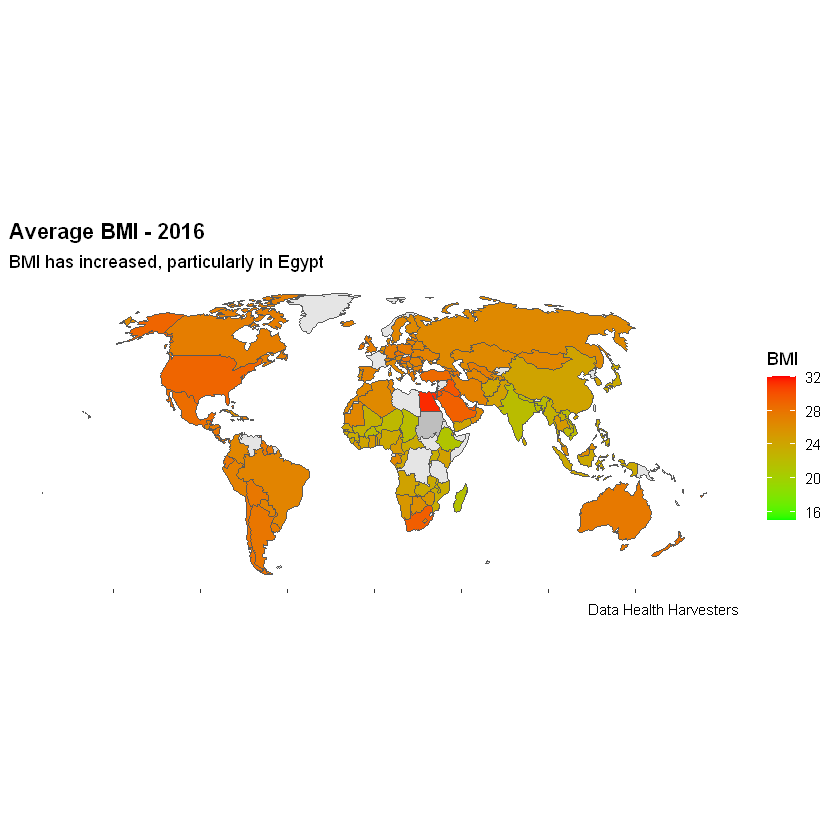

In [51]:
world_plot_bmi_16 <- world %>%
  filter(admin != "Antarctica") %>%
  st_transform(crs = "+proj=robin") %>%
  ggplot() +
geom_sf() +
  geom_sf(data = dfmap %>% 
          filter(year == 2016), 
          aes(fill = bmi_ave)) +
  scale_fill_gradient(limits = c(15, 32), 
                      low = 'green', 
                      high = 'red', 
                      na.value = 'gray') +
  theme(
    plot.title = element_text(face = "bold"),
    axis.text.x = element_blank(),
    plot.background = element_rect(fill = "white"),  # Set the background color for the entire chart area
    panel.background = element_blank()  # Remove the panel background
  ) +
  labs(title = "Average BMI - 2016",
       subtitle = 'BMI has increased, particularly in Egypt',
       x = NULL, y = NULL,
      fill = 'BMI',
      caption = 'Data Health Harvesters')

#ggsave("world_plot_bmi.png", plot = world_plot_bmi)
world_plot_bmi_16

There has been a sizable increase in BMI, but it is interesting to note that some of the central African countries have changed very little.

**Death Plots**

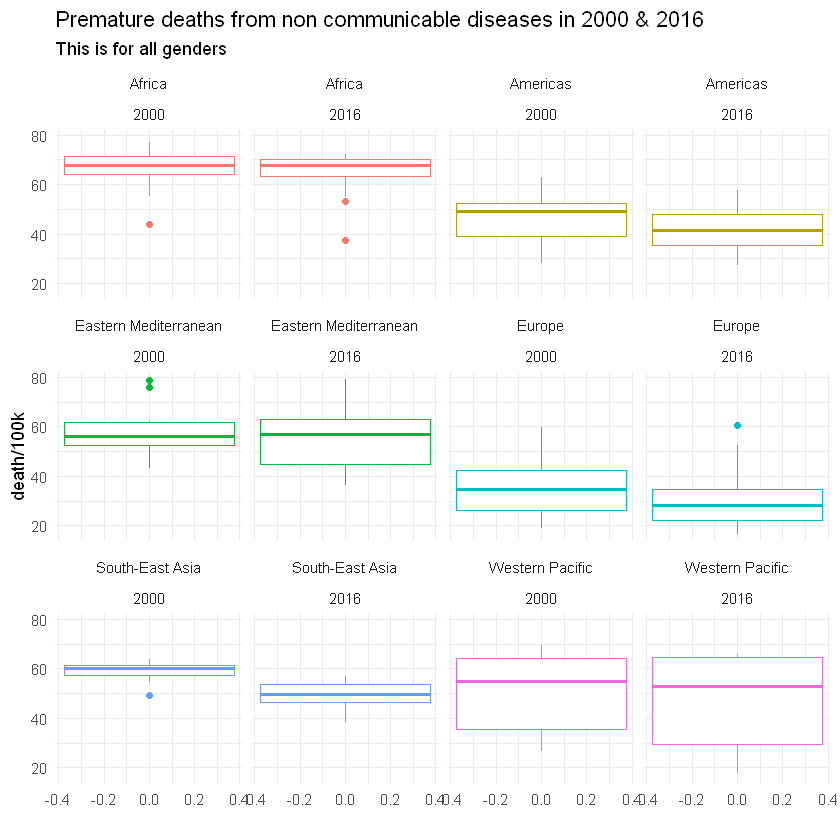

In [52]:
death_ts = merged_data %>% 
    filter(year == 2000|
           year == 2016) %>%
  ggplot(aes(y = deaths_average_gender,
            colour = region)) + 
  geom_boxplot() + #removes the standard bars and sets line width
  labs(title = 'Premature deaths from non communicable diseases in 2000 & 2016',
       subtitle = 'This is for all genders ',
       x = '',
       y = 'death/100k') +
  facet_wrap(~region+year) + #this creates a graph for each region
  theme_minimal() + #I like how this looks
  guides(colour = "none")  #this line removes the colour legend

death_ts

This explains some of the changing socio-economic factors in the world.  There is general trend of the mean decreasing over time.  The Mediterranean has had some outliers decrease, this has skewed their data downwards.  It is difficult to tell from just this chart what the sole driver for the death rate reduction - but we can see a decrease.

**Does sugar Consumption Play a role in BMI?**

Warning message:
"Removed 12 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 12 rows containing missing values (`geom_point()`)."


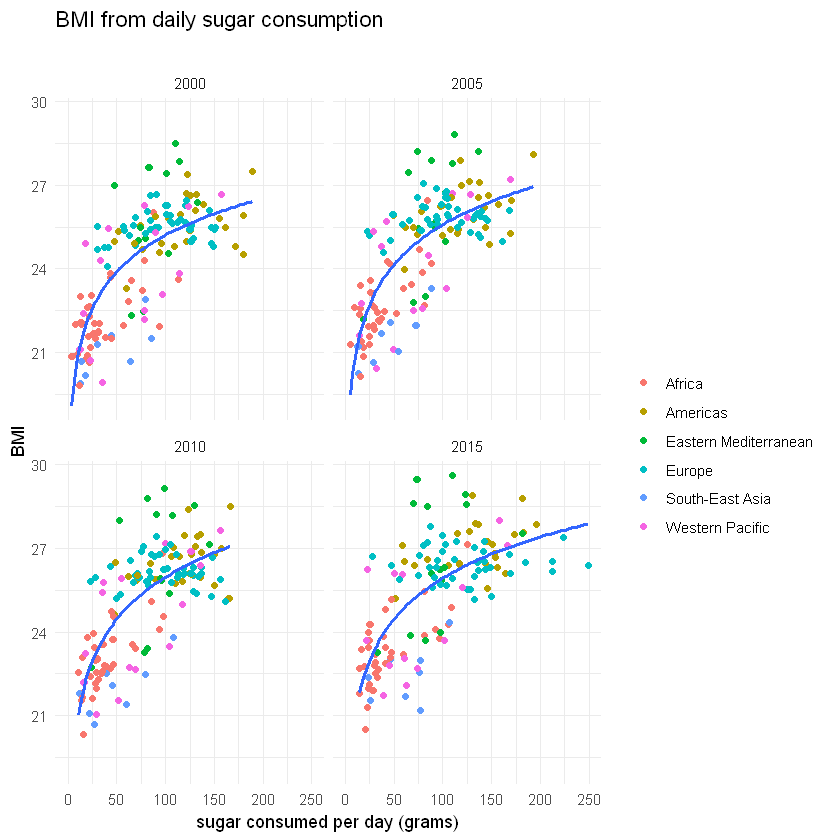

In [53]:
merged_data %>%
  filter(year =='2000'|
         year =='2005'|
         year =='2010'|
         year =='2015') %>%
  ggplot(aes(x = daily_sugar_pp_grams, y = bmi_ave_gender)) + 
  geom_jitter(aes(colour = region)) +
  geom_smooth(method='lm', 
              formula = y ~ log(x), #assume a log relationshiop.  it is likely that 
              se = FALSE, linewidth=1) +  #the relationship is concave.
  xlim(0,250) +
  labs(title = 'BMI from daily sugar consumption ',
       subtitle = '',
       x = 'sugar consumed per day (grams)',
       y = 'BMI',
       colour = '') +
  facet_wrap(~year) + #this creates a graph for each specified year
  theme_minimal()

There is definetly a correlation between daily sugar consumption and bmi, the plots show that increased daily sugar consumption correlates with a higher bmi. 

We can also assume that higher sugar consumption causes a higher bmi, the 4 plots all show the same relationship which means that it is not a coincidence. 
Research also shows that eating too much sugar over time can lead to weight gain and obeisity. 

NOTE: access to sugar is more likely in developed countries.  More developed countries have higher BMIs.  There has been a slow increase in the mean and it appears that the coefficient on sugar consumption has stayed constant.  

In [54]:
head(merged_data)

,country_code,year,country,Freedom_index,gini,GDP_per_capita,region,region_code,EU_member,gender,daily_sugar_pp_grams,bmi_ave,bmi_low,bmi_high,min_deaths,max_deaths,deaths,geometry,bmi_ave_gender,deaths_average_gender
,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<MULTIPOLYGON [°]>,<dbl>,<dbl>
76,FJI,2000,Fiji,6,38.0,4000,Western Pacific,WPR,FALSE,Male,78.8,25.1,24.4,25.7,62.74,74.91,69.29,MULTIPOLYGON (((180 -16.067...,26.26667,68.32000
77,FJI,2000,Fiji,6,38.0,4000,Western Pacific,WPR,FALSE,Other,78.8,26.3,25.7,26.8,61.26,74.39,68.41,MULTIPOLYGON (((180 -16.067...,26.26667,68.32000
78,FJI,2000,Fiji,6,38.0,4000,Western Pacific,WPR,FALSE,Female,78.8,27.4,26.7,28.2,59.27,73.73,67.26,MULTIPOLYGON (((180 -16.067...,26.26667,68.32000
79,FJI,2001,Fiji,4,38.1,4040,Western Pacific,WPR,FALSE,Male,90.4,25.2,24.6,25.8,62.10,73.94,68.42,MULTIPOLYGON (((180 -16.067...,26.36667,67.45333
80,FJI,2001,Fiji,4,38.1,4040,Western Pacific,WPR,FALSE,Other,90.4,26.4,25.9,26.8,60.64,73.45,67.56,MULTIPOLYGON (((180 -16.067...,26.36667,67.45333
81,FJI,2001,Fiji,4,38.1,4040,Western Pacific,WPR,FALSE,Female,90.4,27.5,26.8,28.3,58.59,72.79,66.38,MULTIPOLYGON (((180 -16.067...,26.36667,67.45333


**GDP chart**

Firstly, the x axis had to be logged to allow graphical representation.

This is an interesting chart.  We can see that there is a positive relationship between BMI and GDP - this is well known, as GDP indicates an on average greater access to food.

We also observe the distribution of the various countries by region.  We can see the increase in the GDP in countries from the Americas.  The log scale makes it a little hard to interp

`geom_smooth()` using formula = 'y ~ x'


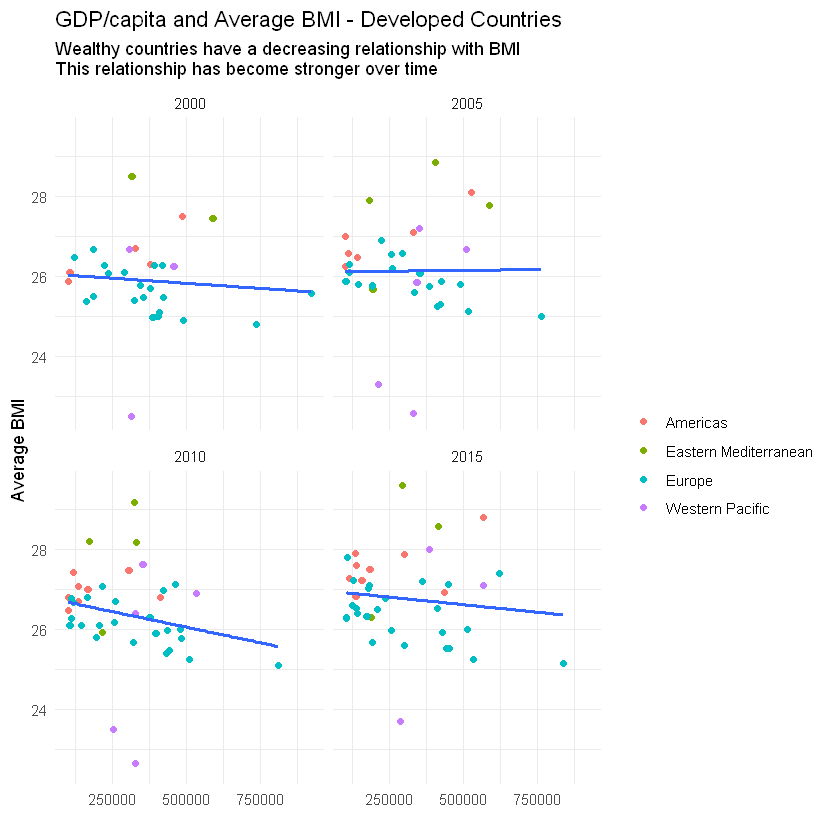

In [55]:
merged_data %>%
  filter(year =='2000'|
         year =='2005'|
         year =='2010'|
         year =='2015',
         GDP_per_capita > 56000) %>%
  ggplot(aes(x = GDP_per_capita, y = bmi_ave_gender)) + 
  geom_jitter(aes(colour = region)) +
  geom_smooth(method='lm', se = FALSE, linewidth=1) +
  labs(title = 'GDP/capita and Average BMI - Developed Countries',
       subtitle = 'Wealthy countries have a decreasing relationship with BMI\nThis relationship has become stronger over time',
       x = '',
       y = 'Average BMI',
       colour = '') +
  facet_wrap(~year) + #this creates a graph for each specified year
  theme_minimal()

This one is for emerging market & developing countries.  It's interesting to note the opposite relationship between GDP and BMI.  Perhaps there is a turning point.  It is also possible that the increasing number of European countries is skewing the true relationship.  Referring to earlier charts on BMI distribution by region we can see that Europe has a very low and tight BMI range.

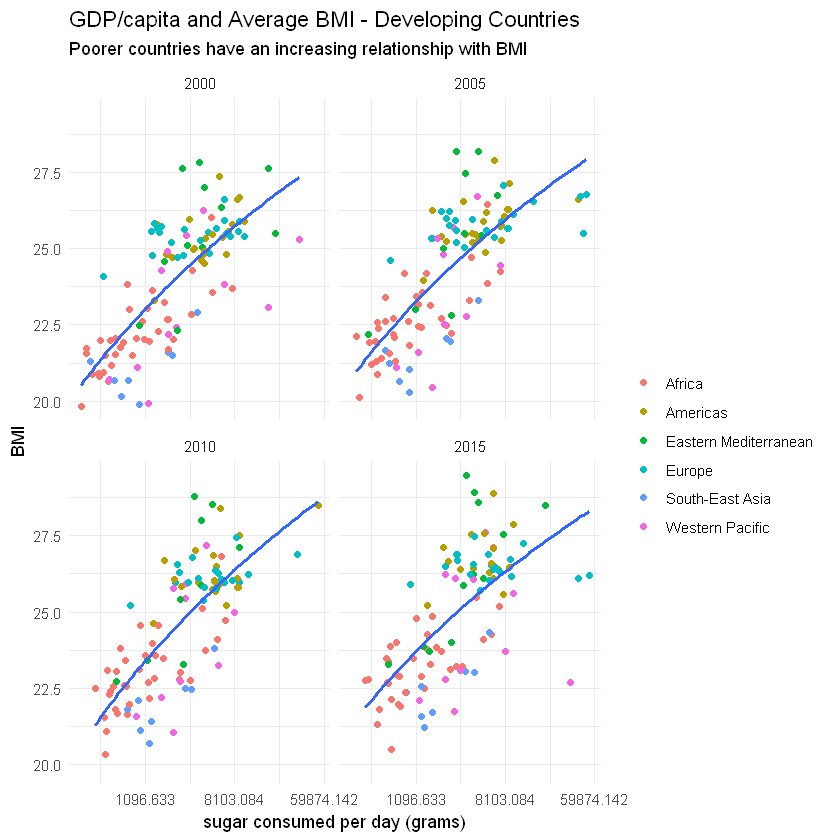

In [56]:
merged_data %>%
  filter(year =='2000'|
         year =='2005'|
         year =='2010'|
         year =='2015',
         GDP_per_capita <= 56000) %>%
  ggplot(aes(x = GDP_per_capita, y = bmi_ave_gender)) + 
  geom_jitter(aes(colour = region)) +
  geom_smooth(method='lm', 
              formula = y ~ log(x), #assume a log relationshiop.  it is likely that 
              se = FALSE, linewidth=1) +  #the relationship is concave.
  scale_x_continuous(trans = 'log') +
  labs(title = 'GDP/capita and Average BMI - Developing Countries',
       subtitle = 'Poorer countries have an increasing relationship with BMI',
       x = 'sugar consumed per day (grams)',
       y = 'BMI',
       colour = '') +
  facet_wrap(~year) + #this creates a graph for each specified year
  theme_minimal()